<a href="https://colab.research.google.com/github/1pritesh1/100-days-of-python/blob/master/Copy_of_Copy_of_NY_Taxi_Fare_Predict_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
0# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('project-3-ny-taxi-fare-prediction')
jovian.set_colab_id('1XdgSCYQ9x3k00cPd1PWNXyenvpkrZwgq')

In [ ]:
import pandas as pd
import numpy as np
!pip install pyarrow --upgrade --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train = '/content/drive/MyDrive/train.csv'
test = '/content/drive/MyDrive/test.csv'

In [ ]:
%%time
df = pd.read_csv(train ,nrows = 400000)

CPU times: user 715 ms, sys: 63.2 ms, total: 778 ms
Wall time: 817 ms


In [ ]:
%%time
test_df = pd.read_csv(test)

CPU times: user 19.7 ms, sys: 994 µs, total: 20.7 ms
Wall time: 23.2 ms


In [ ]:
test_df.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [ ]:
selected_cols = ['fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count']

selected_dtypes = {
    'passenger_count': 'int16',
    'fare_amount':'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32' 
}

In [ ]:
%%time
df3 = pd.read_csv(train,
                  usecols=selected_cols,
                  dtype=selected_dtypes, 
                  parse_dates=['pickup_datetime'],nrows = 400000)

CPU times: user 56.2 s, sys: 160 ms, total: 56.4 s
Wall time: 56.5 s


In [ ]:
selected_cols = ['key','pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count']
df3_test = pd.read_csv(test,
                  usecols=selected_cols,
                  dtype=selected_dtypes, 
                  parse_dates=['pickup_datetime'])

## Add date features**

In [ ]:
def datefeatures(dataTbl):
  dataTbl['year']=dataTbl['pickup_datetime'].dt.year
  dataTbl['day']=dataTbl['pickup_datetime'].dt.day
  dataTbl['month']=dataTbl['pickup_datetime'].dt.month
  dataTbl['weekday']=dataTbl['pickup_datetime'].dt.weekday
  dataTbl['hour']=dataTbl['pickup_datetime'].dt.hour
  dataTbl.drop('pickup_datetime', axis = 1, inplace = True)
  return  dataTbl.head(5)

In [ ]:
datefeatures(df3)
datefeatures(df3_test)

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,day,month,weekday,hour
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,2015,27,1,1,13
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,2015,27,1,1,13
2,2011-10-08 11:53:44.0000002,-73.982521,40.751259,-73.979652,40.746140,1,2011,8,10,5,11
3,2012-12-01 21:12:12.0000002,-73.981163,40.767807,-73.990448,40.751637,1,2012,1,12,5,21
4,2012-12-01 21:12:12.0000003,-73.966049,40.789776,-73.988564,40.744427,1,2012,1,12,5,21


In [ ]:
# remove all rows where lat and long outside Ny
df3.drop(df3[(df3.pickup_longitude < -79) | (df3.pickup_longitude > -71) | 
              (df3.pickup_latitude < 40) | (df3.pickup_latitude > 45)].index,axis=0,inplace=True)

df3.drop(df3[(df3.dropoff_longitude < -79) | (df3.dropoff_longitude > -71) | 
              (df3.dropoff_latitude < 40) | (df3.dropoff_latitude > 45)].index,axis=0,inplace=True)

## Add Distance using geo info

#### Distance Using geopanda

In [ ]:
pip install geopy

In [ ]:
import geopy.distance

In [ ]:
def geodesic_dist(df):
    pickup_lat = df['pickup_latitude']
    pickup_long = df['pickup_longitude']
    dropoff_lat = df['dropoff_latitude']
    dropoff_long = df['dropoff_longitude']
    distance = geopy.distance.geodesic((pickup_lat, pickup_long), 
                                       (dropoff_lat, dropoff_long)).km
    try:
        return distance
    except ValueError:
        return np.nan
    
def circle_dist(df):
    pickup_lat = df['pickup_latitude']
    pickup_long = df['pickup_longitude']
    dropoff_lat = df['dropoff_latitude']
    dropoff_long = df['dropoff_longitude']
    distance = geopy.distance.great_circle((pickup_lat, pickup_long), 
                                       (dropoff_lat, dropoff_long)).km
    try:
        return distance
    except ValueError:
        return np.nan

def latlong_diff(df):
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    # Add new features
    df['latdiff'] = (lat1 - lat2)
    df['londiff'] = (lon1 - lon2)
    df['euclidean'] = (df['latdiff'] ** 2 + df['londiff'] ** 2) ** 0.5

def geo_desc_grtCir(df):
    df.dropna(inplace=True)
    df['geopyDesic_dist'] = df.apply(lambda x: geodesic_dist(x), axis = 1 )
    df['geopyGrtCir_dist'] = df.apply(lambda x: circle_dist(x), axis = 1 )

In [ ]:
geo_desc_grtCir(df3)

In [ ]:
latlong_diff(df3)

In [ ]:
df3

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,day,month,weekday,hour,geopyDesic_dist,geopyGrtCir_dist,latdiff,londiff,euclidean
0,4.5,-73.844315,40.721317,-73.841614,40.712276,1,2009,15,6,0,17,1.029579,1.030744,0.009041,-0.002701,0.009436
1,16.9,-74.016045,40.711304,-73.979271,40.782005,1,2010,5,1,1,16,8.443307,8.450012,-0.070702,-0.036774,0.079693
2,5.7,-73.982735,40.761269,-73.991241,40.750561,2,2011,18,8,3,0,1.389240,1.389634,0.010708,0.008507,0.013676
3,7.7,-73.987129,40.733143,-73.991570,40.758091,1,2012,21,4,5,4,2.795730,2.799214,-0.024948,0.004440,0.025340
4,5.3,-73.968094,40.768009,-73.956657,40.783764,1,2010,9,3,1,7,1.998262,1.999084,-0.015755,-0.011436,0.019468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,7.0,-73.987015,40.729763,-74.005898,40.728611,1,2013,25,11,0,12,1.600310,1.596282,0.001152,0.018883,0.018918
399996,8.5,-73.994080,40.750862,-73.989906,40.769836,2,2013,17,12,1,10,2.136346,2.138927,-0.018974,-0.004173,0.019428
399997,35.0,-73.986496,40.672901,-73.958138,40.765011,1,2014,17,12,2,7,10.505528,10.517291,-0.092110,-0.028358,0.096376
399998,14.1,-73.983521,40.730171,-73.988182,40.779221,4,2011,16,1,6,16,5.461099,5.468165,-0.049049,0.004662,0.049270


https://www.netstate.com/states/geography/ny_geography.htm

In [ ]:
%%time
df3.to_csv('NY_Updated_Data.csv', index=False)

In [ ]:
%%time
df3_test.to_csv('NY_Updated_Test_Data.csv', index=False)

CPU times: user 104 ms, sys: 7.42 ms, total: 112 ms
Wall time: 109 ms


In [ ]:
df3_test

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,day,month,weekday,hour,distance,geopyDesic_dist,geopyGrtCir_dist
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,2015,27,1,1,13,2.323358,2.320991,2.323263
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,2015,27,1,1,13,2.425299,2.423802,2.425356
2,2011-10-08 11:53:44.0000002,-73.982521,40.751259,-73.979652,40.746140,1,2011,8,10,5,11,0.618403,0.617966,0.618413
3,2012-12-01 21:12:12.0000002,-73.981163,40.767807,-73.990448,40.751637,1,2012,1,12,5,21,1.960912,1.959416,1.960781
4,2012-12-01 21:12:12.0000003,-73.966049,40.789776,-73.988564,40.744427,1,2012,1,12,5,21,5.387211,5.382810,5.387288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,-73.968124,40.796997,-73.955643,40.780388,6,2015,10,5,6,12,2.124599,2.124110,2.124877
9910,2015-01-12 17:05:51.0000001,-73.945511,40.803600,-73.960213,40.776371,6,2015,12,1,0,17,3.271138,3.268511,3.270974
9911,2015-04-19 20:44:15.0000001,-73.991600,40.726608,-73.789742,40.647011,6,2015,19,4,6,20,19.183577,19.217032,19.183968
9912,2015-01-31 01:05:19.0000005,-73.985573,40.735432,-73.939178,40.801731,6,2015,31,1,5,1,8.343392,8.339644,8.343498


In [ ]:
df3.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'month', 'weekday', 'hour', 'distance', 'geopyDesic_dist',
       'geopyGrtCir_dist', 'latdiff', 'londiff', 'euclidean'],
      dtype='object')

## Data Cleaning

In [ ]:
def dataClean(df):
    # drop all rows where fare amount is less than 50 cent or higher than $150.

    df.drop(df[df['fare_amount'] < 0.5].index, axis=0, inplace = True)
    df.drop(df[df['fare_amount'] > 150].index, axis=0, inplace = True)

    # drop all rows where passenger count is zero

    df.drop(df[df['passenger_count'] == 0].index, axis=0, inplace = True)

    # drop all row where long and lat is outside newyork

    df.drop(df[(df.pickup_longitude < -79) | (df.pickup_longitude > -71) | 
              (df.pickup_latitude < 40) | (df.pickup_latitude > 45)].index,axis=0,inplace=True)

    df.drop(df[(df.dropoff_longitude < -79) | (df.dropoff_longitude > -71) | 
              (df.dropoff_latitude < 40) | (df.dropoff_latitude > 45)].index,axis=0,inplace=True)
    
    # Drop all rows where fare amount is not in line with distance
    df.drop(df[(df.fare_amount > 5) & (df.geopyDesic_dist < 0.001)].index, axis=0, inplace = True)
    df.drop(df[(df.fare_amount < 20) & (df.geopyDesic_dist >150)].index, axis=0, inplace = True)


    return df

In [ ]:
df3.shape

(390236, 16)

In [ ]:
dataClean(df3)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,day,month,weekday,hour,geopyDesic_dist,geopyGrtCir_dist,latdiff,londiff,euclidean
0,4.5,-73.844315,40.721317,-73.841614,40.712276,1,2009,15,6,0,17,1.029579,1.030744,0.009041,-0.002701,0.009436
1,16.9,-74.016045,40.711304,-73.979271,40.782005,1,2010,5,1,1,16,8.443307,8.450012,-0.070702,-0.036774,0.079693
2,5.7,-73.982735,40.761269,-73.991241,40.750561,2,2011,18,8,3,0,1.389240,1.389634,0.010708,0.008507,0.013676
3,7.7,-73.987129,40.733143,-73.991570,40.758091,1,2012,21,4,5,4,2.795730,2.799214,-0.024948,0.004440,0.025340
4,5.3,-73.968094,40.768009,-73.956657,40.783764,1,2010,9,3,1,7,1.998262,1.999084,-0.015755,-0.011436,0.019468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,7.0,-73.987015,40.729763,-74.005898,40.728611,1,2013,25,11,0,12,1.600310,1.596282,0.001152,0.018883,0.018918
399996,8.5,-73.994080,40.750862,-73.989906,40.769836,2,2013,17,12,1,10,2.136346,2.138927,-0.018974,-0.004173,0.019428
399997,35.0,-73.986496,40.672901,-73.958138,40.765011,1,2014,17,12,2,7,10.505528,10.517291,-0.092110,-0.028358,0.096376
399998,14.1,-73.983521,40.730171,-73.988182,40.779221,4,2011,16,1,6,16,5.461099,5.468165,-0.049049,0.004662,0.049270


In [ ]:
df3.shape

(387152, 16)

## Save DF to CSV /feather*

In [ ]:
df3 = pd.read_feather('NY_Updated_Data.feather')

In [ ]:
df3.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'month', 'weekday', 'hour', 'distance', 'geopyDesic_dist',
       'geopyGrtCir_dist', 'Fare per k/m'],
      dtype='object')

In [ ]:
df3.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,day,month,weekday,hour,distance,geopyDesic_dist,geopyGrtCir_dist,Fare per k/m
count,385221.000000,385221.000000,385221.000000,385221.000000,385221.000000,385221.000000,385221.000000,385221.000000,385221.000000,385221.000000,385221.000000,385221.000000,385221.000000,385221.000000,385221.000000
mean,11.301880,-73.998222,40.874714,-73.998268,40.875866,1.690251,2011.744684,15.671721,6.276299,3.041693,13.510600,3.389573,3.390619,3.389580,5.435536
std,9.470420,0.046377,0.127075,0.045571,0.128576,1.306367,1.867031,8.681774,3.439939,1.948550,6.510648,3.965195,3.969135,3.965470,21.657330
min,2.500000,-78.650909,40.052723,-78.659447,40.041180,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.002553,0.002129,0.002129,0.020000
25%,6.000000,-73.992287,40.736637,-73.991554,40.735695,1.000000,2010.000000,8.000000,3.000000,1.000000,9.000000,1.285923,1.286503,1.285871,2.970000
50%,8.500000,-73.982109,40.753471,-73.980591,40.753960,1.000000,2012.000000,16.000000,6.000000,3.000000,14.000000,2.185232,2.185659,2.185190,3.810000
75%,12.500000,-73.968498,40.767525,-73.965446,40.768414,2.000000,2013.000000,23.000000,9.000000,5.000000,19.000000,3.964424,3.963499,3.964440,5.030000
max,281.049988,-71.056412,43.183331,-71.035461,43.415192,6.000000,2015.000000,31.000000,12.000000,6.000000,23.000000,343.669189,344.545070,343.669544,993.400024


## Exploratory Data Analysis

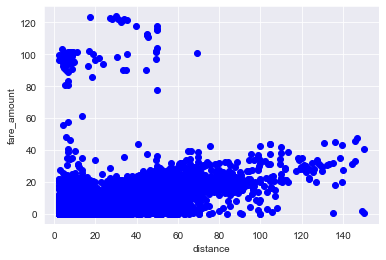

In [ ]:
plt.scatter(df3.fare_amount, df3.distance,color='blue')
plt.xlabel("distance")
plt.ylabel("fare_amount")
plt.show();

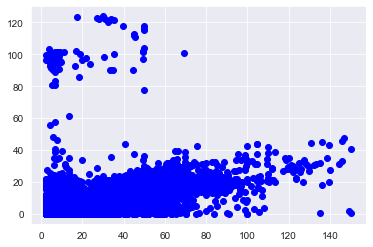

In [ ]:
plt.scatter( df3.fare_amount,df3.distance,color='blue')
plt.show();

In [ ]:
## 

## prepare the dataset for training

In [ ]:
inputs_df

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,day,month,weekday,hour,distance,geopyDesic_dist,geopyGrtCir_dist,latdiff,londiff,euclidean
0,0.628560,0.219500,0.629327,0.198902,0.0,0.000000,0.466667,0.454545,0.000000,0.739130,0.008329,0.008296,0.008326,0.429500,0.500151,0.006418
1,0.606103,0.216213,0.611346,0.219568,0.0,0.166667,0.133333,0.000000,0.166667,0.695652,0.068256,0.068031,0.068258,0.376597,0.488537,0.054210
2,0.610459,0.232616,0.609782,0.210249,0.2,0.333333,0.566667,0.636364,0.500000,0.000000,0.011225,0.011194,0.011225,0.430606,0.503971,0.009303
3,0.609884,0.223382,0.609739,0.212480,0.0,0.500000,0.666667,0.272727,0.833333,0.173913,0.022614,0.022526,0.022612,0.406951,0.502585,0.017237
4,0.612373,0.234829,0.614299,0.220089,0.0,0.166667,0.266667,0.181818,0.166667,0.304348,0.016147,0.016101,0.016148,0.413050,0.497173,0.013243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,0.609899,0.222273,0.607867,0.203743,0.0,0.666667,0.800000,0.909091,0.000000,0.521739,0.012897,0.012894,0.012895,0.424266,0.507508,0.012869
399996,0.608975,0.229200,0.609956,0.215962,0.2,0.666667,0.533333,1.000000,0.166667,0.434783,0.017278,0.017213,0.017278,0.410914,0.499649,0.013216
399997,0.609967,0.203605,0.614106,0.214531,0.0,0.833333,0.533333,1.000000,0.333333,0.304348,0.084957,0.084647,0.084958,0.362395,0.491405,0.065559
399998,0.610356,0.222407,0.610182,0.218743,0.6,0.333333,0.500000,0.000000,1.000000,0.695652,0.044173,0.044002,0.044171,0.390962,0.502660,0.033515


In [ ]:
df3.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'day', 'month', 'weekday', 'hour', 'distance', 'geopyDesic_dist',
       'geopyGrtCir_dist', 'latdiff', 'londiff', 'euclidean'],
      dtype='object')

In [ ]:
# Drop unwanted columns
dropped_columns = ['pickup_longitude', 'pickup_latitude', 
                   'dropoff_longitude', 'dropoff_latitude','distance']
df3 = df3.drop(dropped_columns, axis=1)

In [ ]:
df4=df3.copy()

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Identify input and target columns
input_cols, target_col = df4.columns[1:], df4.columns[:1]
inputs_df, targets = df4[input_cols].copy(), df4[target_col].copy()

# Identify numeric and categorical columns
numeric_cols = df4[input_cols].select_dtypes(include=np.number).columns.tolist()


In [ ]:
imputer = SimpleImputer().fit(inputs_df[numeric_cols])

### #Impute and scale numeric columns
imputer = SimpleImputer().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

In [ ]:

# Create training and validation sets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[numeric_cols], targets, test_size=0.25, random_state=42)

## decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
tree = DecisionTreeRegressor(random_state=42)

In [ ]:
# Fit the model to the training data
tree.fit(train_inputs,train_targets)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
tree_train_preds = tree.predict(train_inputs)

In [ ]:
tree_train_preds

array([ 8.10000038, 16.        , 13.        , ...,  4.9000001 ,
        6.5       , 11.30000019])

In [ ]:
tree_train_rmse = mean_squared_error(train_targets,tree_train_preds,squared=False)

In [ ]:
tree_val_preds = tree.predict(val_inputs)

In [ ]:
tree_val_rmse = mean_squared_error(val_targets,tree_val_preds,squared=False)

In [ ]:
print('Train RMSE: {}, Validation RMSE: {}'.format(tree_train_rmse, tree_val_rmse))

Train RMSE: 0.0, Validation RMSE: 4.908723172585197


In [ ]:
df4['fare_amount'].mean()

11.29724407196045

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

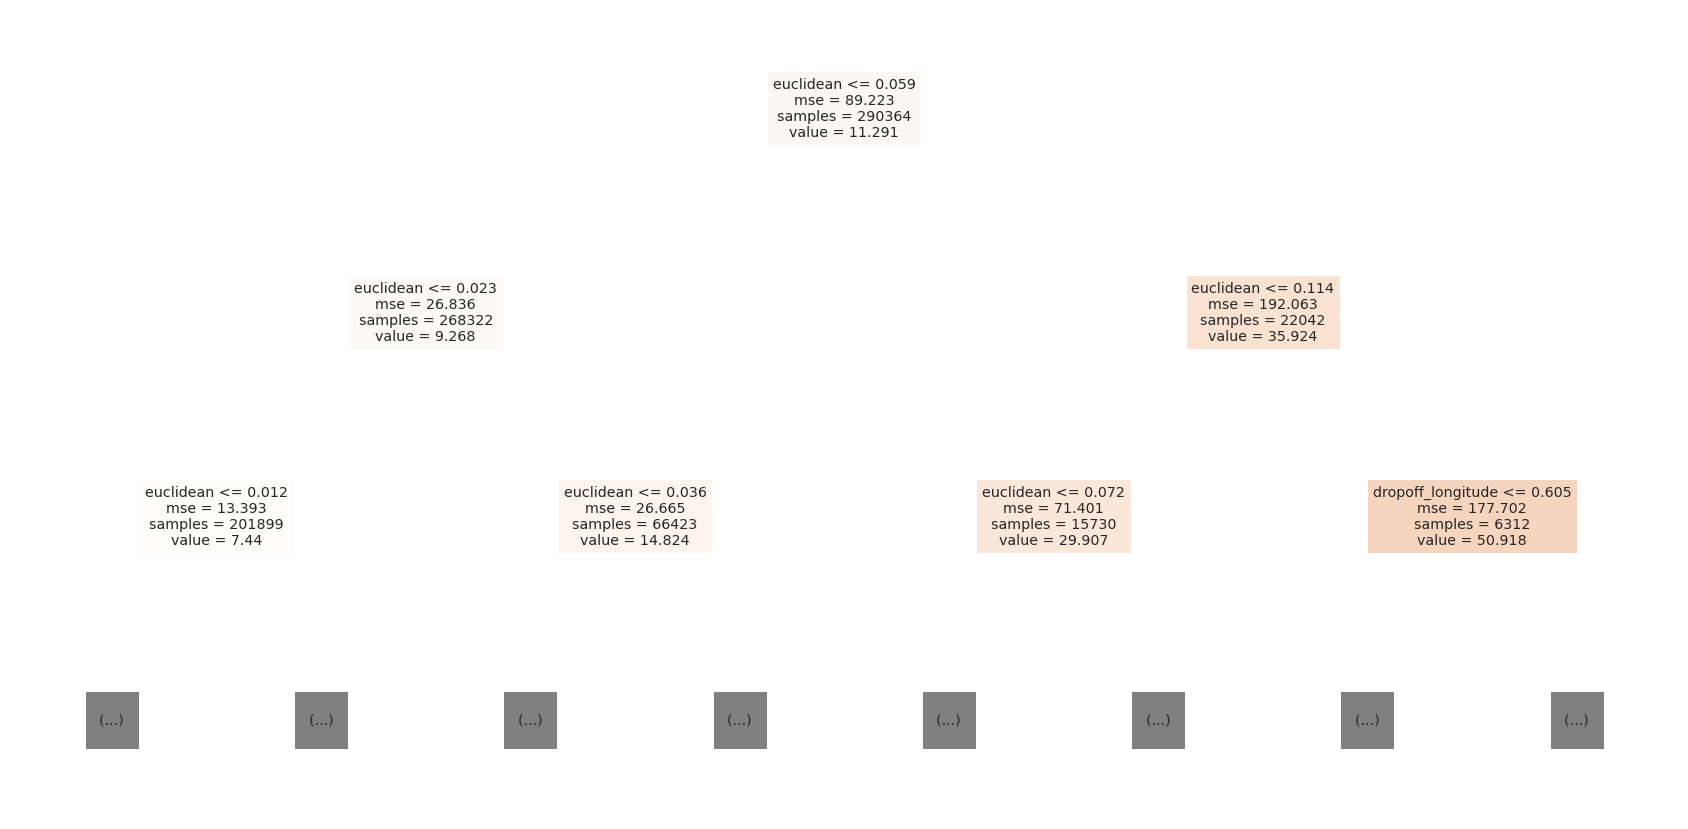

In [ ]:
plt.figure(figsize=(30,15))

# Visualize the tree graphically using plot_tree
plot_tree(tree, feature_names=train_inputs.columns, max_depth=2, filled=True);

In [ ]:
# Visualize the tree textually using export_text
tree_text = export_text(tree, max_depth=10, feature_names=list(train_inputs.columns))

In [ ]:
# Display the first few lines
print(tree_text[:2000])

|--- euclidean <= 0.06
|   |--- euclidean <= 0.02
|   |   |--- euclidean <= 0.01
|   |   |   |--- pickup_longitude <= 0.63
|   |   |   |   |--- euclidean <= 0.01
|   |   |   |   |   |--- pickup_longitude <= 0.61
|   |   |   |   |   |   |--- euclidean <= 0.00
|   |   |   |   |   |   |   |--- geopyDesic_dist <= 0.00
|   |   |   |   |   |   |   |   |--- day <= 0.53
|   |   |   |   |   |   |   |   |   |--- euclidean <= 0.00
|   |   |   |   |   |   |   |   |   |   |--- passenger_count <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- passenger_count >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [5.00]
|   |   |   |   |   |   |   |   |   |--- euclidean >  0.00
|   |   |   |   |   |   |   |   |   |   |--- value: [2.50]
|   |   |   |   |   |   |   |   |--- day >  0.53
|   |   |   |   |   |   |   |   |   |--- hour <= 0.83
|   |   |   |   |   |   |   |   |   |   |--- value: [2.50]
|   |   |   |   | 

In [ ]:
# Check feature importance
tree_importances = tree.feature_importances_

In [ ]:
tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

In [ ]:
tree_importance_df

,feature,importance
14,euclidean,0.806618
2,dropoff_longitude,0.030483
5,year,0.024115
0,pickup_longitude,0.021004
12,latdiff,0.017596
3,dropoff_latitude,0.017563
13,londiff,0.014633
1,pickup_latitude,0.012119
11,geopyGrtCir_dist,0.011922
9,hour,0.011101


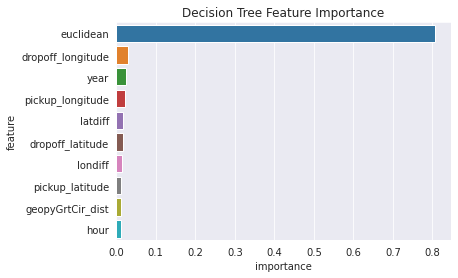

In [ ]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Create the model
rf1 = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_leaf=4, max_features=0.4)

In [ ]:
# Fit the model
rf1.fit(train_inputs,train_targets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=0.4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
rf1_train_preds = rf1.predict(train_inputs)

In [ ]:
rf1_train_rmse = mean_squared_error(train_targets,rf1_train_preds,squared=False)

In [ ]:
rf1_val_preds = rf1.predict(val_inputs)

In [ ]:
rf1_val_rmse = mean_squared_error(val_targets,rf1_val_preds,squared=False)

In [ ]:
print('Train RMSE: {}, Validation RMSE: {}'.format(rf1_train_rmse, rf1_val_rmse))

Train RMSE: 3.296740821964689, Validation RMSE: 3.616772741871909


## Hyperparameter Tuning


In [ ]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

In [ ]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [ ]:
test_params(n_estimators=50, max_depth=10, min_samples_leaf=4, max_features=0.4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(3.2944689809853425, 3.6139466008241716)

<ipython-input-332-0a934fac384a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
<ipython-input-332-0a934fac384a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
<ipython-input-332-0a934fac384a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
<ipython-input-332-0a934fac384a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

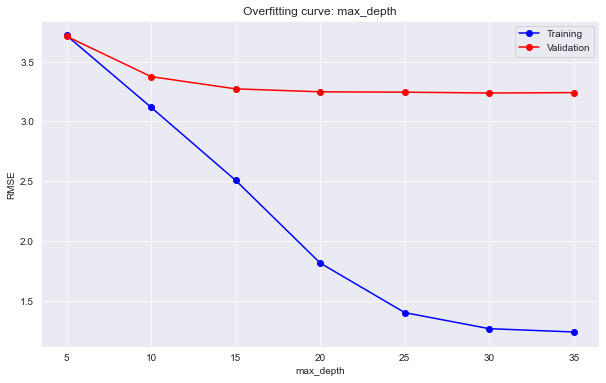

In [ ]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

In [ ]:
test_params(n_estimators=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(1.4114097254305, 3.5883642759109198)

In [ ]:
test_params(n_estimators=35)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(1.320714779831337, 3.5232343593507816)

In [ ]:
test_params(n_estimators=75)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(1.2763350877760467, 3.5117780687322195)

#### This seems to be a best fit param for RandomForrest

In [ ]:
test_params(n_estimators=35, max_depth=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(3.1968016742121717, 3.630390590774698)

# Validate Test Data

In [ ]:

df3_test.columns

Index(['key', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'year', 'day', 'month',
       'weekday', 'hour', 'distance', 'geopyDesic_dist', 'geopyGrtCir_dist'],
      dtype='object')

In [ ]:
selected_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'year', 'day', 'month',
       'weekday', 'hour', 'distance', 'geopyDesic_dist', 'geopyGrtCir_dist']

In [ ]:
train_inputs.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'year', 'day', 'month',
       'weekday', 'hour', 'distance', 'geopyDesic_dist', 'geopyGrtCir_dist'],
      dtype='object')

In [ ]:
a=rf1.predict(df3_test[selected_cols])

In [ ]:
a[:100]

array([73.13113351, 73.13113351, 71.48955307, 73.13113351, 73.13113351,
       73.13113351, 74.49056931, 73.13113351, 73.13113351, 73.13113351,
       73.13113351, 73.13113351, 69.77531364, 72.85336079, 73.13113351,
       73.13113351, 89.1071986 , 73.13113351, 69.1214756 , 74.46375151,
       73.13113351, 73.13113351, 73.13113351, 73.13113351, 73.13113351,
       73.13113351, 73.13113351, 73.13113351, 73.13113351, 73.13113351,
       73.13113351, 73.13113351, 73.13113351, 73.13113351, 73.13113351,
       73.13113351, 73.13113351, 73.13113351, 73.13113351, 70.05308635,
       73.13113351, 73.13113351, 73.13113351, 73.13113351, 72.51113722,
       73.13113351, 74.49056931, 73.13113351, 73.13113351, 70.05308635,
       73.13113351, 73.13113351, 73.13113351, 73.13113351, 73.13113351,
       73.13113351, 73.13113351, 73.13113351, 73.13113351, 73.13113351,
       73.13113351, 73.13113351, 69.25196449, 74.1117836 , 73.13113351,
       73.13113351, 73.13113351, 73.13113351, 72.51113722, 73.13

In [ ]:
df3_test

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,day,month,weekday,hour,distance,geopyDesic_dist,geopyGrtCir_dist
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,2015,27,1,1,13,2.323358,2.320991,2.323263
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,2015,27,1,1,13,2.425299,2.423802,2.425356
2,2011-10-08 11:53:44.0000002,-73.982521,40.751259,-73.979652,40.746140,1,2011,8,10,5,11,0.618403,0.617966,0.618413
3,2012-12-01 21:12:12.0000002,-73.981163,40.767807,-73.990448,40.751637,1,2012,1,12,5,21,1.960912,1.959416,1.960781
4,2012-12-01 21:12:12.0000003,-73.966049,40.789776,-73.988564,40.744427,1,2012,1,12,5,21,5.387211,5.382810,5.387288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,-73.968124,40.796997,-73.955643,40.780388,6,2015,10,5,6,12,2.124599,2.124110,2.124877
9910,2015-01-12 17:05:51.0000001,-73.945511,40.803600,-73.960213,40.776371,6,2015,12,1,0,17,3.271138,3.268511,3.270974
9911,2015-04-19 20:44:15.0000001,-73.991600,40.726608,-73.789742,40.647011,6,2015,19,4,6,20,19.183577,19.217032,19.183968
9912,2015-01-31 01:05:19.0000005,-73.985573,40.735432,-73.939178,40.801731,6,2015,31,1,5,1,8.343392,8.339644,8.343498


In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Identify input and target columns
input_cols, target_col = df3.columns[1:], df3.columns[:1]
inputs_df, targets = df3[input_cols].copy(), df3[target_col].copy()